# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.8.0'

#### Load Image Data

In [4]:
DATA_LIST = os.listdir('two/train') #split into covid/train
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.001 # start off with high rate first 0.001 and experiment with reducing it gradually

#### Generate Training and Validation Batches

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [7]:
print(train_batches.image_shape)

(224, 224, 3)


In [8]:
#use pretrained VGG16 model, removed the classification layer, set model weights to not be trained
#after flattening from the output of block5_pooling layer in VGG16, added 1 fully connected layers followed by dropout,
#with final fully connected output layer using sigmoid activation function

base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_batches.image_shape)

model = models.Sequential([
    tf.keras.Model(inputs=base_model.input, outputs=base_model.output, name="vgg16"),
    layers.Flatten(name="flatten"),
    layers.Dense(256, activation='relu', name="dense1"),
    layers.Dropout(0.3, name="dropout1"),
    layers.Dense(1, activation="sigmoid", name="pred_dense")
])

model.get_layer("vgg16").trainable=False

#summary of model architecture
model.summary()

#compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense1 (Dense)              (None, 256)               6422784   
                                                                 
 dropout1 (Dropout)          (None, 256)               0         
                                                                 
 pred_dense (Dense)          (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#implement early stopping: stop training of the model early if there's no increase in param such as validation acc
#and model checkpoint

#### [5 points] Train Model

In [9]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

history = model.fit(train_batches, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_batches, validation_steps=STEP_SIZE_VALID, epochs=NUM_EPOCHS)

11
3


/share/pkg.7/tensorflow/2.8.0/install/lib/SCC/../python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.8.0/install/lib/SCC/../python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
10/10 [==============================] - 55s 6s/step - loss: 2.5340 - accuracy: 0.4600 - val_loss: 0.4098 - val_accuracy: 0.8000
Epoch 2/40
10/10 [==============================] - 51s 5s/step - loss: 0.5923 - accuracy: 0.7553 - val_loss: 0.3929 - val_accuracy: 0.8500
Epoch 3/40
10/10 [==============================] - 51s 5s/step - loss: 0.6619 - accuracy: 0.8191 - val_loss: 0.3241 - val_accuracy: 0.9000
Epoch 4/40
10/10 [==============================] - 51s 5s/step - loss: 0.4334 - accuracy: 0.8617 - val_loss: 0.2994 - val_accuracy: 0.8500
Epoch 5/40
10/10 [==============================] - 50s 5s/step - loss: 0.5320 - accuracy: 0.8191 - val_loss: 0.4931 - val_accuracy: 0.9000
Epoch 6/40
10/10 [==============================] - 51s 5s/step - loss: 0.2497 - accuracy: 0.9255 - val_loss: 0.1338 - val_accuracy: 1.0000
Epoch 7/40
10/10 [==============================] - 51s 5s/step - loss: 0.3957 - accuracy: 0.8617 - val_loss: 0.0763 - val_accuracy: 1.0000
Epoch 8/40
10/10 [==

#### [5 points] Plot Accuracy and Loss During Training

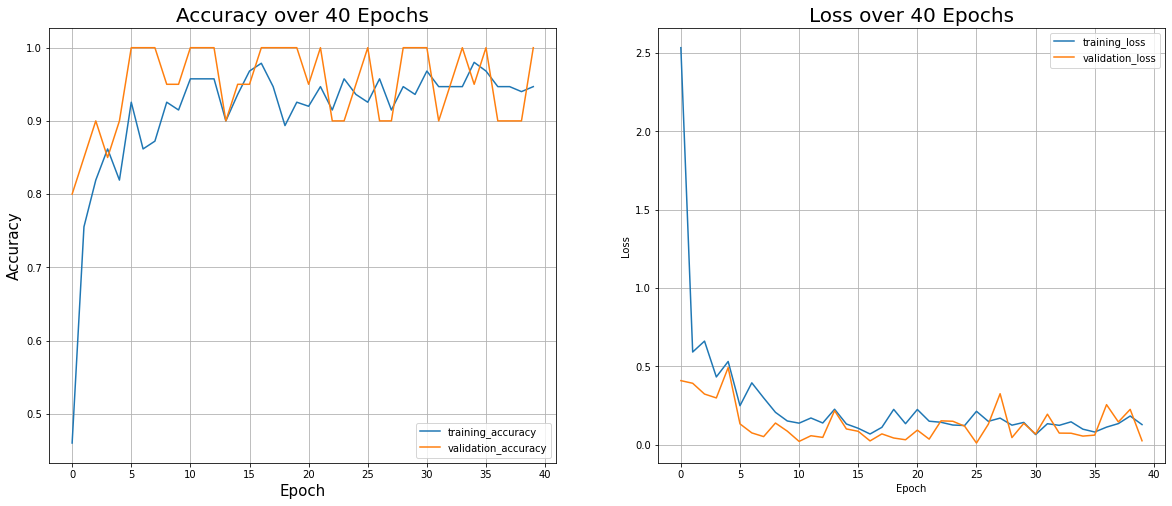

In [10]:
plt.figure(figsize=(20,8))

#plot the accuracies for the training and validation sets
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.title('Accuracy over %s Epochs' % NUM_EPOCHS, fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.grid()
plt.legend(loc='lower right')

#plot the loss for the training and validation sets
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.title('Loss over %s Epochs' % NUM_EPOCHS, fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')


#### Plot Test Results

Found 18 images belonging to 2 classes.


<ipython-input-11-aa0cc9a8f179>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(eval_generator,18,verbose=1)


18/18 [==============================] - 8s 439ms/step
covid/nejmoa2001191_f3-PA.jpeg


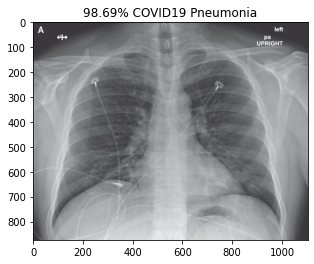

covid/nejmoa2001191_f4.jpeg


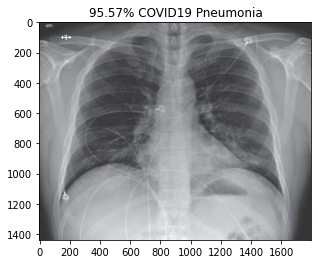

covid/nejmoa2001191_f5-PA.jpeg


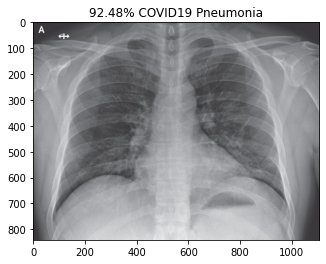

covid/radiol.2020200490.fig3.jpeg


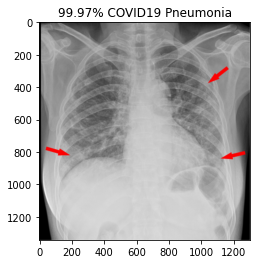

covid/ryct.2020200028.fig1a.jpeg


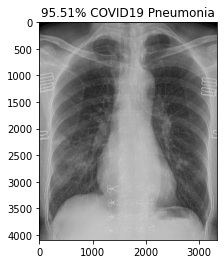

covid/ryct.2020200034.fig2.jpeg


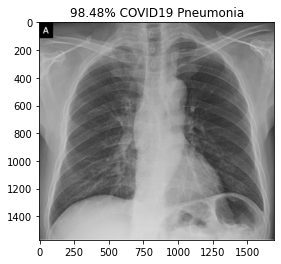

covid/ryct.2020200034.fig5-day0.jpeg


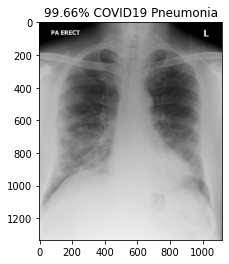

covid/ryct.2020200034.fig5-day4.jpeg


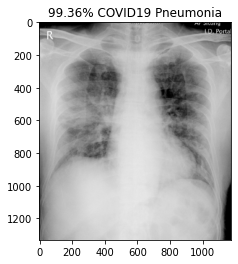

covid/ryct.2020200034.fig5-day7.jpeg


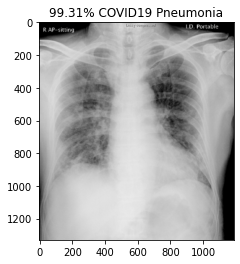

normal/NORMAL2-IM-1385-0001.jpeg


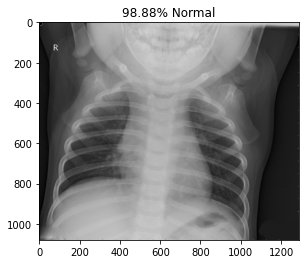

normal/NORMAL2-IM-1396-0001.jpeg


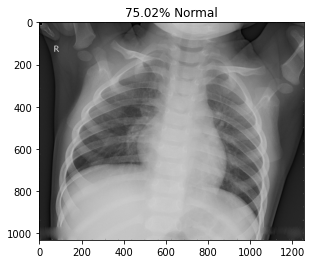

normal/NORMAL2-IM-1400-0001.jpeg


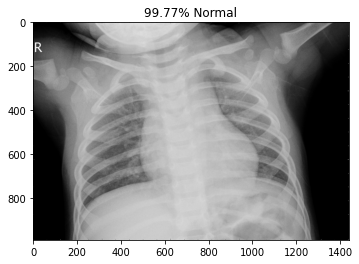

normal/NORMAL2-IM-1401-0001.jpeg


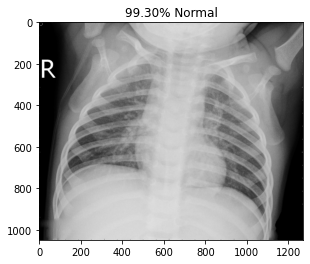

normal/NORMAL2-IM-1406-0001.jpeg


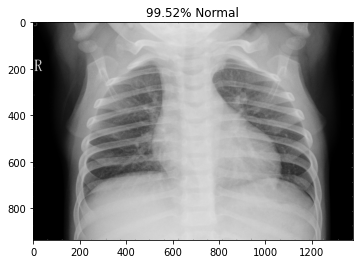

normal/NORMAL2-IM-1412-0001.jpeg


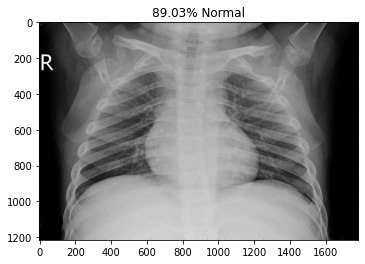

normal/NORMAL2-IM-1419-0001.jpeg


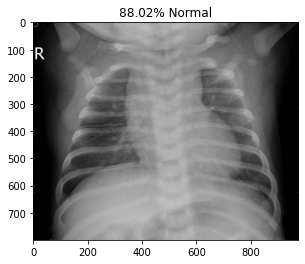

normal/NORMAL2-IM-1422-0001.jpeg


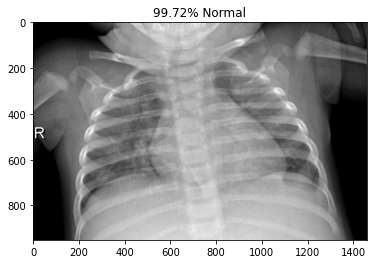

normal/NORMAL2-IM-1423-0001.jpeg


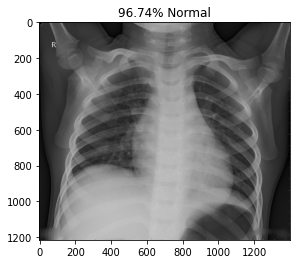

In [11]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

In [17]:
#evaluate accuracy on test set
x = model.evaluate(eval_generator,steps = np.ceil(len(eval_generator)),verbose = 1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

18/18 [==============================] - 8s 428ms/step - loss: 0.0449 - accuracy: 1.0000
Test loss: 0.04485663026571274
Test accuracy: 1.0


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [19]:
from sklearn.manifold import TSNE

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense1').output)

tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")


Found 130 images belonging to 2 classes.


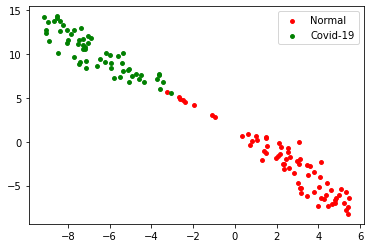

In [21]:
features = intermediate_layer_model.predict(tsne_data_generator)
label = tsne_data_generator.class_indices
classes = tsne_data_generator.classes

fea_tsne = TSNE().fit_transform(features)
X,Y = zip(*fea_tsne)

X_Nor=[]
Y_Nor=[]

X_Cov=[]
Y_Cov=[]

for x,y,c in zip(X,Y,classes):
    if(label['covid']==c):
        X_Cov.append(x)
        Y_Cov.append(y)
    else:
        X_Nor.append(x)
        Y_Nor.append(y)
        
plt.scatter(X_Nor, Y_Nor, c='red', label='Normal', s=15)
plt.scatter(X_Cov, Y_Cov, c='green', label='Covid-19', s=15)

plt.legend()
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->